# **Strategic Revenue Management:** An Analysis of Pricing Dynamics in the Online Travel Agent (OTA) Market

This project analyzes hotel pricing data from multiple OTA platforms to uncover crucial relationships between price, ratings, and the competitive landscape. By segmenting the market and comparing platforms, the analysis yields strategic insights that reveal the dominant platforms and cities with the highest price variations, aiming to help OTAs and hotels optimize their pricing strategies.

## **1. Import Libraries**
Imports all the libraries needed for data analysis, visualization, and machine learning: Pandas for data manipulation, Matplotlib/Seaborn for static visualization, Plotly for interactive visualization, and Scikit-learn for clustering.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## **2. Load Data**

Loads a dataset from a CSV file with latin1 encoding to handle special characters. `df.head()` displays the first 5 rows for initial data inspection.

In [20]:
df = pd.read_csv("data/Great deals_Booking Hotels.csv", encoding="latin1")
df.head()

,Hotel/Resort Name,Type of Residence,Area,Rating,Rating.1,Reviews,Booking website 1,Booking website 1_Price,Booking website 2,Booking website 2 -Price,Booking website 3,Booking website 3 -Price,Cancellation Details,Breakfast Provision,Payement option,Discount
0,Hotel Mohegan Sun,Resort,Uncasville,8.8,Excellent,3670,Booking.com,23038,Hotel site,23038.0,NaN,NaN,Free cancellation,NaN,NaN,21%
1,Holiday Inn Express & Suites Clinton,Hotel,Clinton,8.6,Excellent,699,Holiday Inn Express,13889,Booking.com,13890.0,NaN,NaN,Free cancellation,Breakfast included,NaN,Our lowest price
2,Hilton Vacation Club Ocean Beach Club Virginia...,Hotel,Virginia Beach,8,Very good,4539,Booking.com,11096,Hilton Grand Vacations,10738.0,Trip.com,9785.0,Free cancellation,Breakfast included,NaN,20%
3,The San Luis Resort Spa & Conference Center,Serviced apartment,Galveston,8.5,Excellent,2655,Booking.com,24910,Trip.com,26033.0,Agoda,17406.0,Free cancellation,Breakfast included,NaN,NaN
4,Gaylord Texan Resort & Convention Center,Hotel,Grapevine,8.5,Excellent,3691,Booking.com,31958,Gaylord Hotels,31957.0,Prestigia,27310.0,Free cancellation,Breakfast included,Pay at the property,NaN


## **3. Data Preprocessing**

Comprehensive cleaning function that handles:

- Converting ratings and reviews to numeric values ​​with special character handling

- Price column cleaning (removing non-numeric characters)

- Extracting cities from area columns

- Creating aggregate metrics (average, minimum, maximum, and range prices)

- Segmenting prices into 4 categories: Budget, Mid-Range, Premium, and Luxury

In [21]:
def clean_data(df):
    # Copy dataframe
    data = df.copy()
    
    # --- Convert Rating & Reviews to numeric ---
    # Replace non-breaking spaces and strip
    data['Rating'] = data['Rating'].astype(str).str.replace('\xa0', '', regex=False).str.strip()
    data['Reviews'] = data['Reviews'].astype(str).str.replace('\xa0', '', regex=False).str.replace(',', '', regex=False).str.strip()
    
    # Convert to numeric
    data['Rating'] = pd.to_numeric(data['Rating'], errors='coerce')
    data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')
    
    # Fill missing with median
    data['Rating'] = data['Rating'].fillna(data['Rating'].median())
    data['Reviews'] = data['Reviews'].fillna(data['Reviews'].median())
    
    # --- Clean price columns ---
    price_columns = ['Booking website 1_Price', 'Booking website 2 -Price', 
                     'Booking website 3 -Price']
    
    for col in price_columns:
        data[col] = data[col].astype(str).str.replace('[^\d.]', '', regex=True).str.strip()
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].fillna(data[col].median())
    
    # Extract city from Area column
    data['City'] = data['Area'].str.split(',').str[-1].str.strip()
    
    # Create aggregated metrics
    data['Avg_Price'] = data[price_columns].mean(axis=1)
    data['Min_Price'] = data[price_columns].min(axis=1)
    data['Max_Price'] = data[price_columns].max(axis=1)
    data['Price_Range'] = data['Max_Price'] - data['Min_Price']
    
    # Categorize hotels by price segment
    def price_segment(price):
        if price < 10000:
            return 'Budget'
        elif price < 20000:
            return 'Mid-Range'
        elif price < 40000:
            return 'Premium'
        else:
            return 'Luxury'
    
    data['Price_Segment'] = data['Avg_Price'].apply(price_segment)
    
    return data

# Apply cleaning
hotel_data = clean_data(df)

## **4. Exploratory Data Analysis**

### **4.1 Descriptive Statistics**

Generates key descriptive statistics:

- Total hotels and cities in the dataset
- Ratings and average prices
- Ranking of the 10 most expensive cities based on average hotel prices

In [22]:
print(f"Total Hotels: {len(hotel_data)}")
print(f"Total Cities: {hotel_data['City'].nunique()}")
print(f"Average Rating: {hotel_data['Rating'].mean():.2f}")
print(f"Average Price: ${hotel_data['Avg_Price'].mean():.2f}")

# Top cities by average price
city_price = hotel_data.groupby('City').agg({
    'Avg_Price': 'mean',
    'Rating': 'mean',
    'Hotel/Resort Name': 'count'
}).round(2).sort_values('Avg_Price', ascending=False)

print("\nTop 10 Most Expensive Cities:")
print(city_price.head(10))

Total Hotels: 1399
Total Cities: 983
Average Rating: 8.48
Average Price: $12034.25

Top 10 Most Expensive Cities:
                     Avg_Price  Rating  Hotel/Resort Name
City                                                     
Middleburg            71746.33    9.00                  1
Rancho Palos Verdes   66232.33    8.80                  1
Greensboro            63241.67    8.90                  1
West Lafayette        49310.33    9.40                  1
Fort Worth            48791.00    9.30                  1
Truckee               47709.67    9.00                  1
Ojai                  47549.67    9.30                  1
Coronado              45115.67    7.60                  1
Scottsdale            40509.17    8.55                  2
Vail                  38707.00    9.40                  1


### **4.2 Price Distribution by Segment**

Boxplots show price distributions across four hotel segments. This helps understand price variations within each segment and detect outliers.


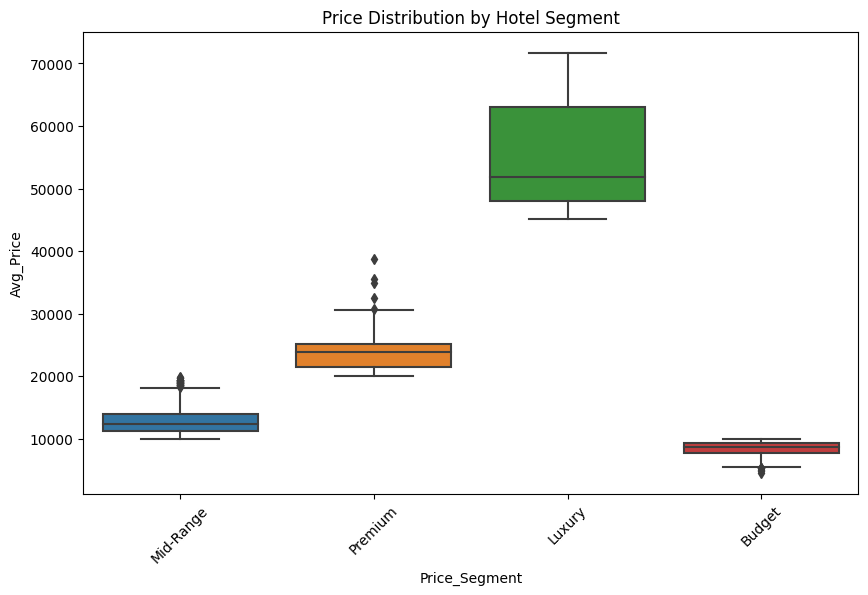

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(data=hotel_data, x='Price_Segment', y='Avg_Price')
plt.title("Price Distribution by Hotel Segment")
plt.xticks(rotation=45)
plt.show()

### **4.3 Rating vs Price Correlation**

Scatter plot with color-coding segments to analyze the relationship between rating and price. Shows whether hotels with higher ratings tend to be more expensive.


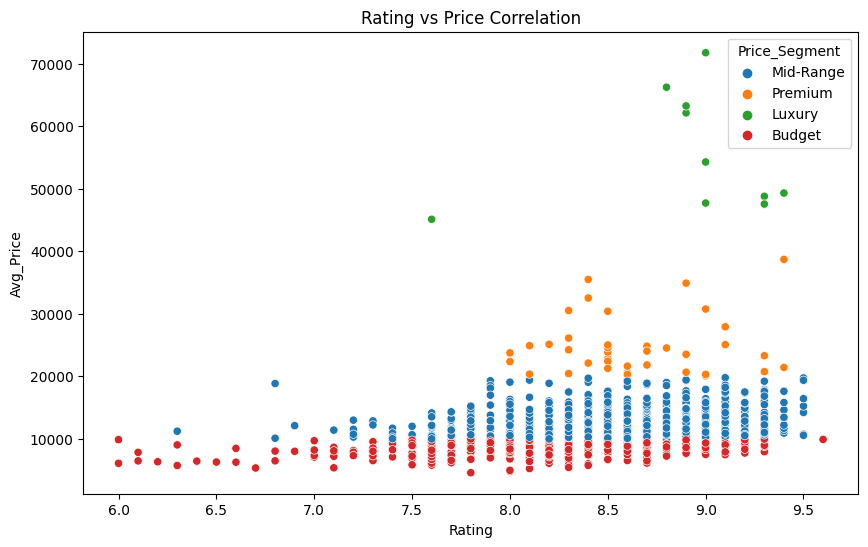

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=hotel_data, x='Rating', y='Avg_Price', hue='Price_Segment')
plt.title("Rating vs Price Correlation")
plt.show()

### **4.4 Top Cities by Average Price**

This bar chart displays the 10 cities with the highest average hotel prices. It's important for identifying market premiums and opportunity pricing.

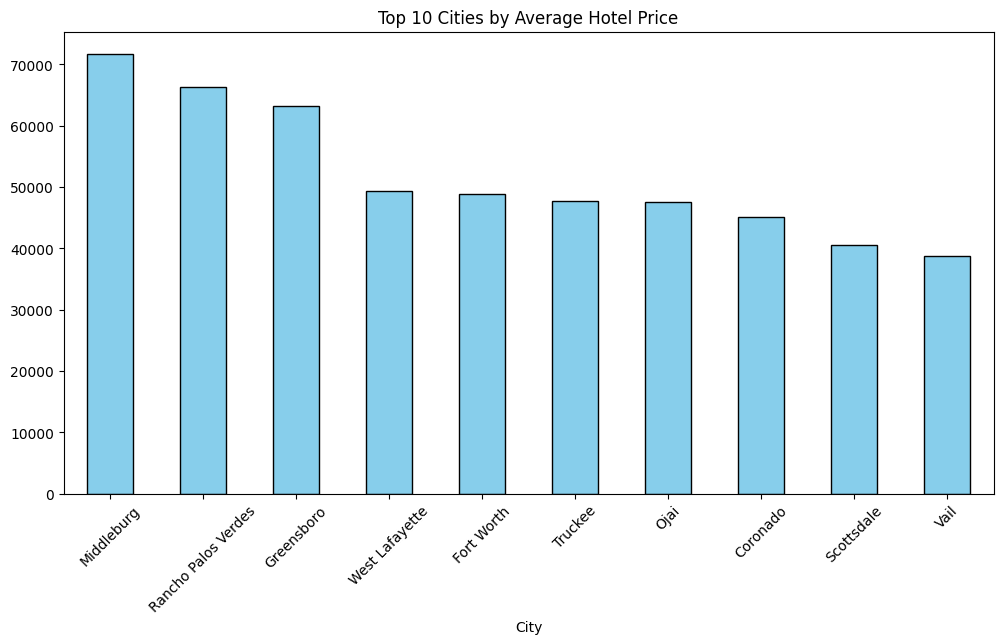

In [25]:
plt.figure(figsize=(12,6))
top_cities = hotel_data.groupby("City")['Avg_Price'].mean().nlargest(10)
top_cities.plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Top 10 Cities by Average Hotel Price")
plt.xticks(rotation=45)
plt.show()

### **4.5 Booking Platform Market Share**

A pie chart shows the dominance of booking platforms based on their frequency of appearance in the dataset. It reveals market leaders and the competitive landscape.

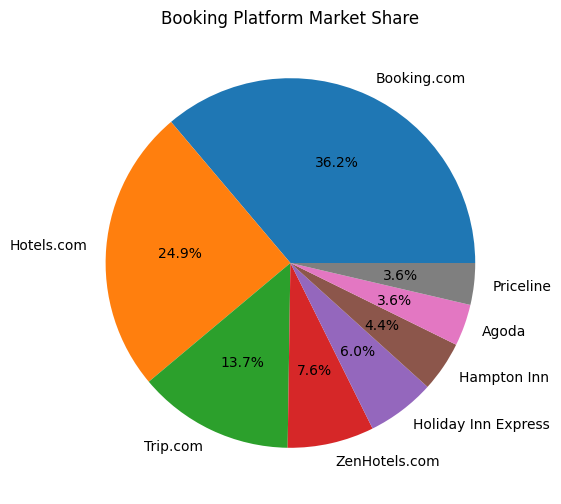

In [26]:
plt.figure(figsize=(6,6))
platforms = pd.concat([
    hotel_data['Booking website 1'].value_counts(),
    hotel_data['Booking website 2'].value_counts(),
    hotel_data['Booking website 3'].value_counts()
])
platform_share = platforms.groupby(platforms.index).sum().nlargest(8)
platform_share.plot(kind='pie', autopct='%1.1f%%')
plt.title("Booking Platform Market Share")
plt.ylabel("")
plt.show()

### **4.6 Distribution of Reviews**

Histogram of the distribution of the number of reviews. Shows customer engagement patterns and the hotel's overall popularity.

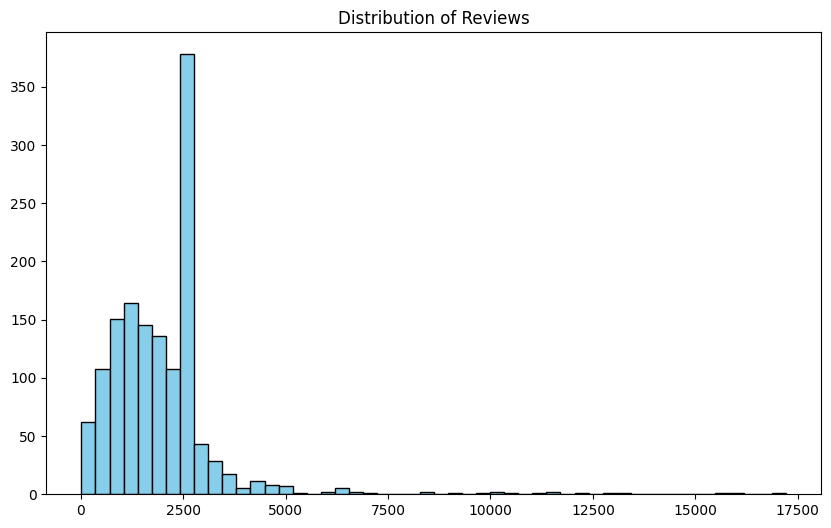

In [27]:
plt.figure(figsize=(10,6))
plt.hist(hotel_data['Reviews'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Reviews")
plt.show()

### **4.7 Average Price by Booking Platform**

Compare average prices across different booking platforms. Identify which platforms offer the most competitive prices.

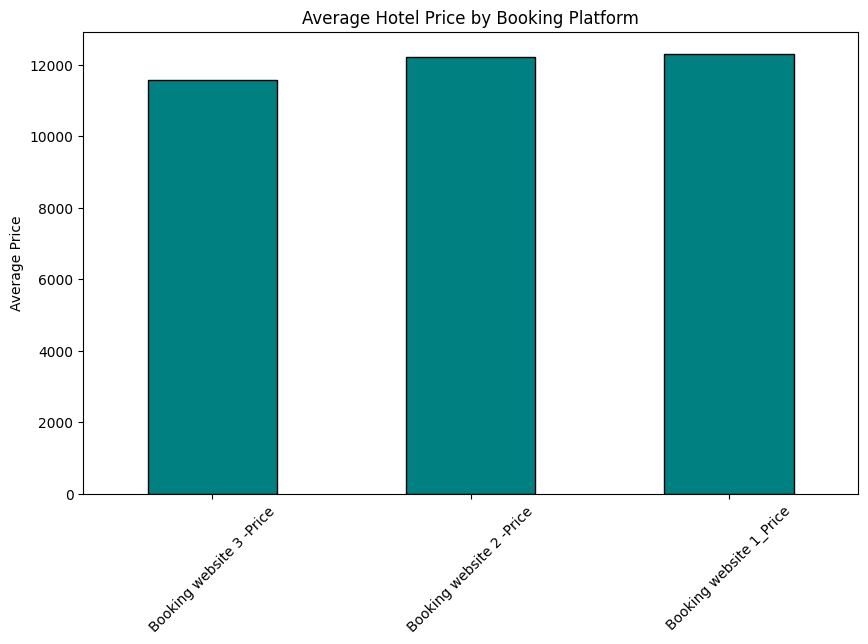

In [28]:
plt.figure(figsize=(10,6))
price_cols = ['Booking website 1_Price', 'Booking website 2 -Price', 'Booking website 3 -Price']
avg_prices = hotel_data[price_cols].mean().sort_values()

avg_prices.plot(kind='bar', color="teal", edgecolor="black")
plt.title("Average Hotel Price by Booking Platform")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

### **4.8 Advanced Visualizations**

- **Scatter plot with log scale:** Analysis of the relationship between reviews and price using a log scale to handle skewness.

- **Rating distribution:** Histogram of hotel rating distribution.

- **Price variation by city:** Cities with the highest price variation across platforms, an indicator of arbitrage opportunity.

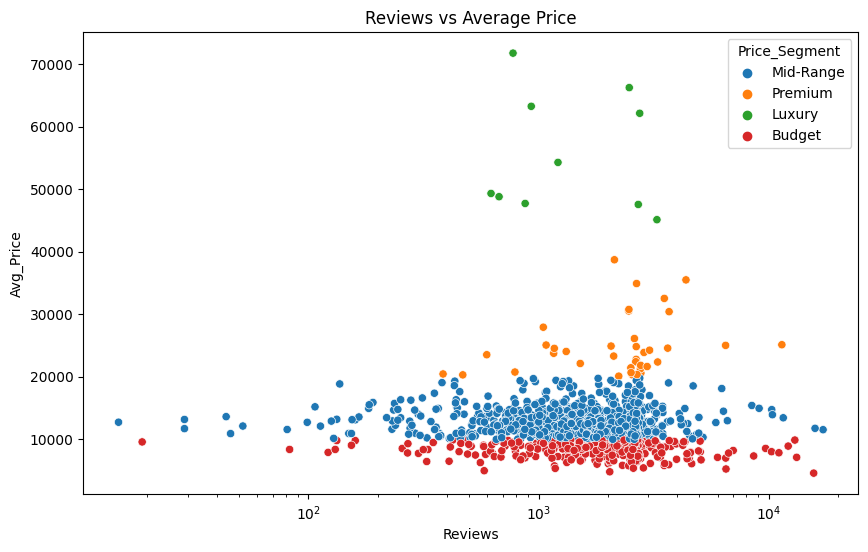

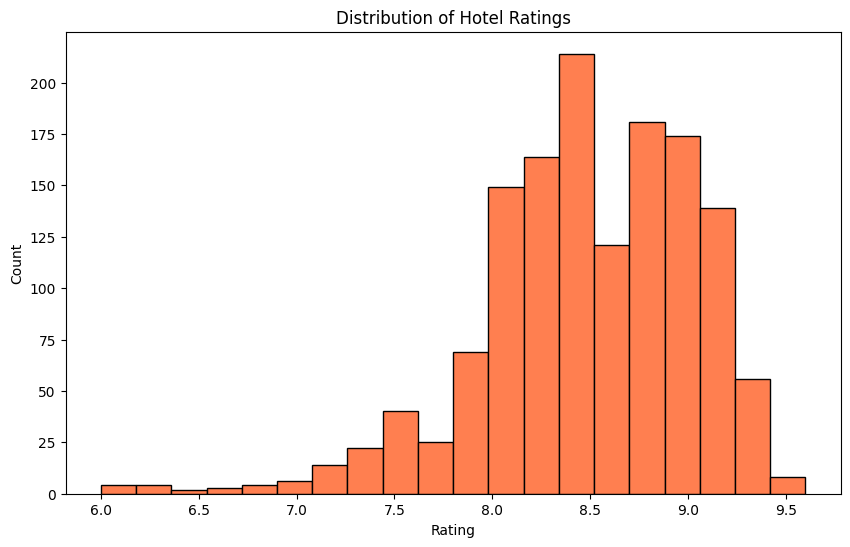

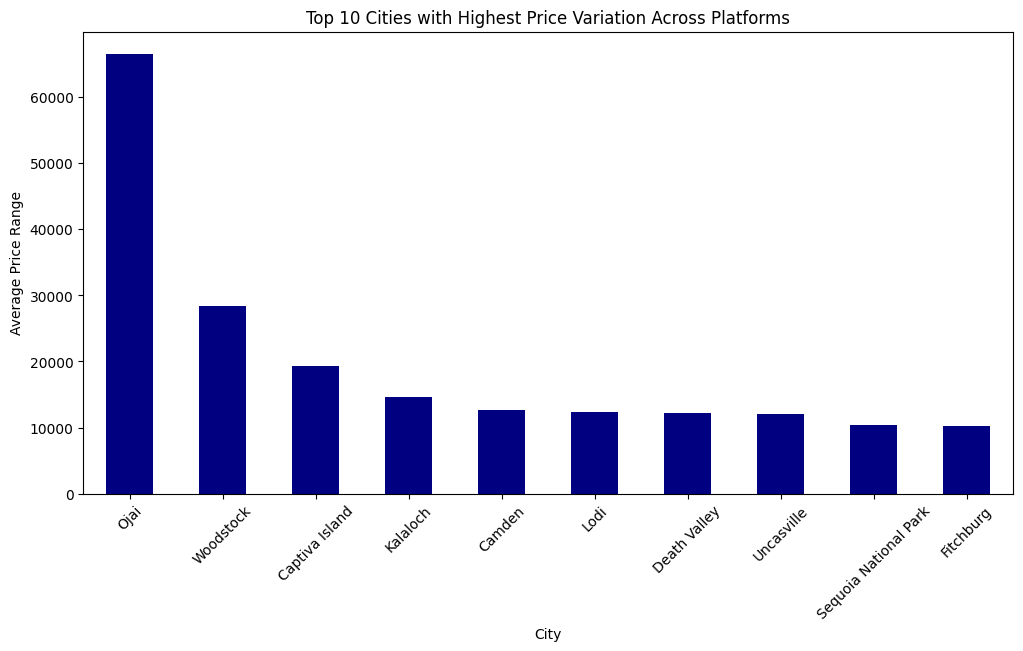

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=hotel_data, x='Reviews', y='Avg_Price', hue='Price_Segment')
plt.title("Reviews vs Average Price")
plt.xscale("log")  # skala log biar tidak berat di ujung
plt.show()

plt.figure(figsize=(10,6))
plt.hist(hotel_data['Rating'].dropna(), bins=20, color="coral", edgecolor="black")
plt.title("Distribution of Hotel Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,6))
city_range = hotel_data.groupby('City')['Price_Range'].mean().nlargest(10)
city_range.plot(kind='bar', color="navy")
plt.title("Top 10 Cities with Highest Price Variation Across Platforms")
plt.ylabel("Average Price Range")
plt.xticks(rotation=45)
plt.show()

### **4.9 Additional Distributions**

- **Price range distribution:** The distribution of maximum and minimum price differences across platforms.

- **Hotel type distribution:** The distribution of accommodation types (Hotels, Resorts, Serviced Apartments, etc.)

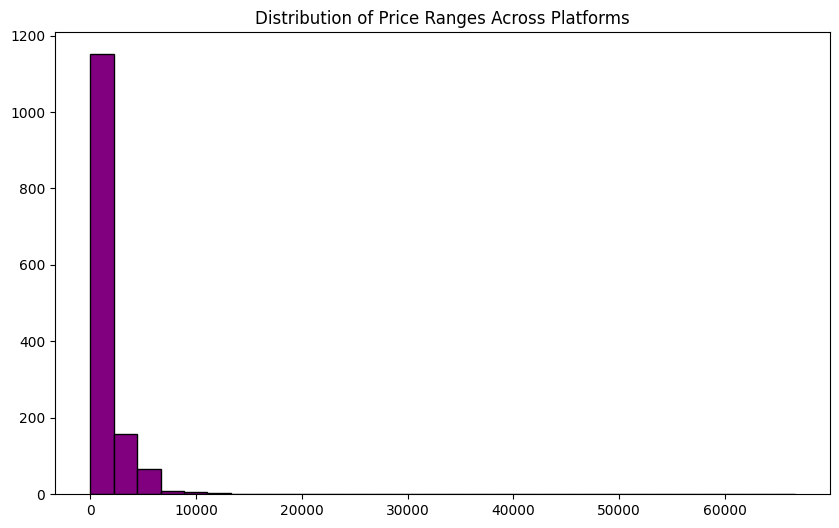

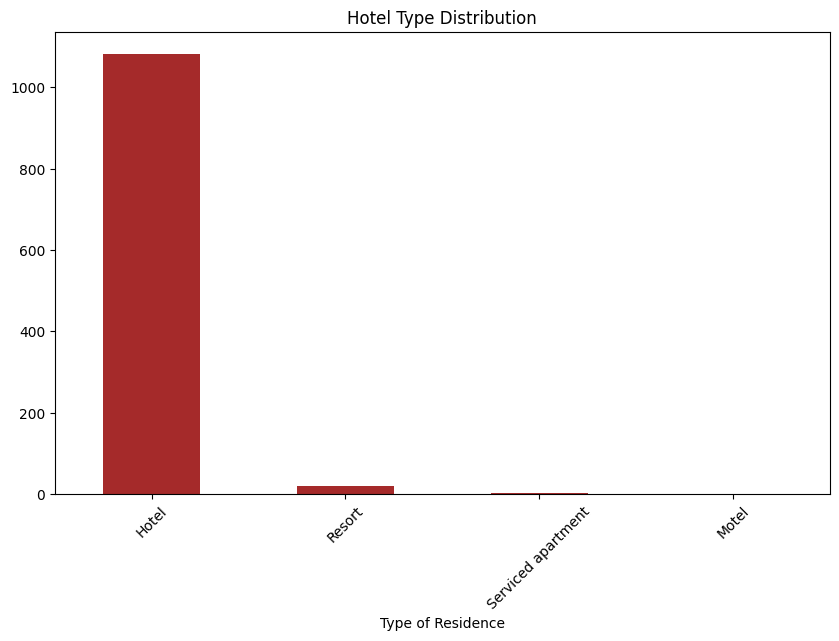

In [30]:
plt.figure(figsize=(10,6))
plt.hist(hotel_data['Price_Range'], bins=30, color="purple", edgecolor="black")
plt.title("Distribution of Price Ranges Across Platforms")
plt.show()

plt.figure(figsize=(10,6))
hotel_types = hotel_data['Type of Residence'].value_counts().head(8)
hotel_types.plot(kind='bar', color="brown")
plt.title("Hotel Type Distribution")
plt.xticks(rotation=45)
plt.show()